In [1]:
import numpy as np
from utils import *

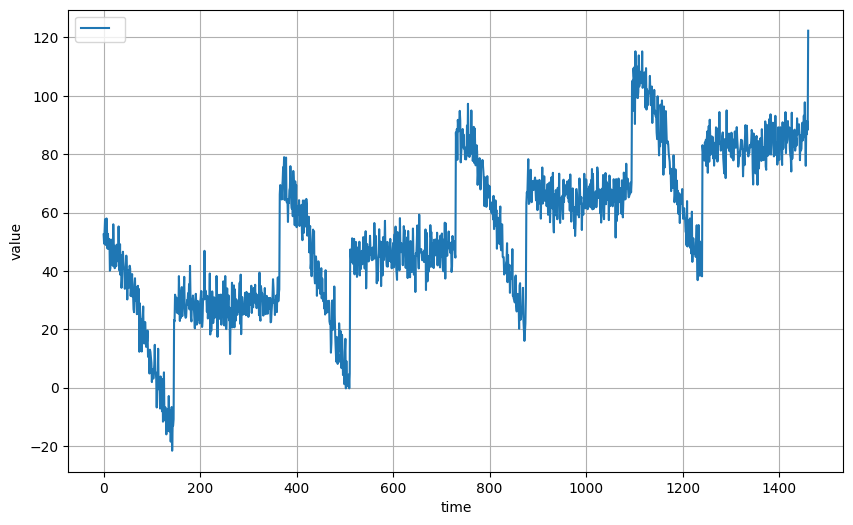

In [2]:
# Parameters
time = np.arange(4 * 365 + 1, dtype="float32")
baseline = 10
amplitude = 40
slope = 0.05
noise_level = 5

# Create the series
series = baseline + trend(time, slope) + seasonality(time, period=365, amplitude=amplitude)

# Update with noise
series += noise(time, noise_level, seed=42)

# Plot the results
plot_series(time, series)

In [3]:
# Define the split time
split_time = 1000

# Get the train set 
time_train = time[:split_time]
x_train = series[:split_time]

# Get the validation set
time_valid = time[split_time:]
x_valid = series[split_time:]

In [4]:
# Parameters
window_size = 20
batch_size = 32
shuffle_buffer_size = 1000

In [5]:
dataset = generate_windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)

# Print shapes of feature and label
for window in dataset.take(1):
  print(f'shape of feature: {window[0].shape}')
  print(f'shape of label: {window[1].shape}')

shape of feature: (32, 20)
shape of label: (32,)


In [6]:
for window in dataset.take(1):
    print(tf.expand_dims(window[0], axis=-1).shape)

(32, 20, 1)


In [7]:
# Build the Model
model_tune = tf.keras.models.Sequential([
  # this lambda layer gives 1 more dimension to the neural network iput data, if you have shape (32,20) it will become (32,20,1)
  tf.keras.layers.Lambda(lambda x: tf.expand_dims(x, axis=-1), 
                      input_shape=[window_size]),
  tf.keras.layers.SimpleRNN(40, return_sequences=True),
  tf.keras.layers.SimpleRNN(40),
  tf.keras.layers.Dense(1),
  tf.keras.layers.Lambda(lambda x: x * 100.0)
])

# Print the model summary
model_tune.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lambda (Lambda)             (None, 20, 1)             0         
                                                                 
 simple_rnn (SimpleRNN)      (None, 20, 40)            1680      
                                                                 
 simple_rnn_1 (SimpleRNN)    (None, 40)                3240      
                                                                 
 dense (Dense)               (None, 1)                 41        
                                                                 
 lambda_1 (Lambda)           (None, 1)                 0         
                                                                 
Total params: 4961 (19.38 KB)
Trainable params: 4961 (19.38 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [8]:
from keras.src.optimizers import Adam

# Set the learning rate scheduler
lr_schedule = tf.keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-8 * 10**(epoch / 20))

# Initialize the optimizer
optimizer = tf.keras.optimizers.SGD(momentum=0.9, learning_rate=5.6234e-06)

# Set the training parameters
model_tune.compile(metrics=["mae"], loss=tf.keras.losses.Huber(), optimizer=optimizer)

# Train the model
history = model_tune.fit(dataset, epochs=100)

Epoch 1/100
31/31 [==============================] - 2s 22ms/step - loss: 10.2863 - mae: 10.7736
Epoch 2/100
31/31 [==============================] - 0s 3ms/step - loss: 8.7543 - mae: 9.2391
Epoch 3/100
31/31 [==============================] - 0s 3ms/step - loss: 7.7089 - mae: 8.1962
Epoch 4/100
31/31 [==============================] - 0s 3ms/step - loss: 7.1036 - mae: 7.5891
Epoch 5/100
31/31 [==============================] - 0s 3ms/step - loss: 6.6276 - mae: 7.1120
Epoch 6/100
31/31 [==============================] - 0s 3ms/step - loss: 6.4112 - mae: 6.8983
Epoch 7/100
31/31 [==============================] - 0s 3ms/step - loss: 6.9516 - mae: 7.4393
Epoch 8/100
31/31 [==============================] - 0s 3ms/step - loss: 6.7498 - mae: 7.2388
Epoch 9/100
31/31 [==============================] - 0s 3ms/step - loss: 6.2554 - mae: 6.7387
Epoch 10/100
31/31 [==============================] - 0s 3ms/step - loss: 7.3782 - mae: 7.8663
Epoch 11/100
31/31 [==============================] - 0s

In [9]:
series[split_time:]

array([ 71.34472 ,  68.98552 ,  64.6752  ,  61.15736 ,  67.89844 ,
        66.390305,  68.91469 ,  67.6307  ,  69.71901 ,  61.81174 ,
        71.091835,  65.51008 ,  74.91588 ,  61.11138 ,  73.25516 ,
        65.58317 ,  61.35506 ,  62.21152 ,  63.048264,  66.79013 ,
        67.30303 ,  61.840164,  64.60695 ,  75.460365,  73.40727 ,
        66.971954,  65.00137 ,  65.43278 ,  67.9217  ,  59.761875,
        63.610905,  56.577053,  66.938515,  68.20101 ,  62.571968,
        72.88092 ,  58.905464,  57.73595 ,  66.20383 ,  70.34101 ,
        73.54933 ,  62.859653,  70.57207 ,  65.010925,  64.36533 ,
        69.671974,  68.5407  ,  57.42275 ,  72.71323 ,  72.256996,
        62.25493 ,  67.38817 ,  67.9059  ,  66.7659  ,  62.737984,
        62.15856 ,  65.41626 ,  71.43522 ,  68.31729 ,  63.774124,
        69.51377 ,  51.440834,  71.45582 ,  57.042038,  63.957195,
        60.20002 ,  59.354107,  71.66096 ,  63.547802,  67.648476,
        65.71117 ,  68.36095 ,  66.39001 ,  59.62124 ,  71.048

In [10]:
start_time = split_time - window_size
end_time = -window_size
forecast = []

for time in range(len(series[start_time:end_time])):
    new_series = series[time + start_time: time + start_time + window_size][np.newaxis]
    forecast.append(model_tune.predict(new_series, verbose=0).reshape(-1).tolist()[0])

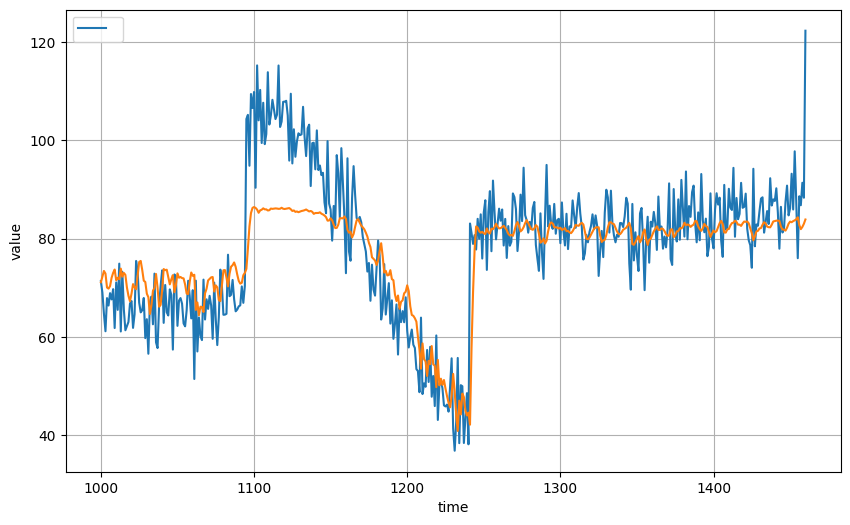

In [11]:
plot_series(time_valid, (x_valid, forecast))